In [1]:
import json
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from databases.mongodb import MongoDB
from databases.blockchain_etl import BlockchainETL
from databases.postgresql import PostgresDB
from copy import deepcopy
from itertools import combinations

DB_PREFIX = ''
with open('./artifacts/centralized_exchange_addresses.json', 'r') as f:
    cex_hot_wallets = json.load(f)

cexes = ['binance', 'coinbase-exchange', 'kucoin', 'bitfinex', 'crypto-com-exchange', 'huobi', 'bybit', 'gate-io', 'binance-us', 'okx', 'mxc', 'bilaxy']
dexes = ["pancakeswap", "spookyswap"]
lending_pools_0 = ['aave', 'venus', 'trava', 'cream', 'valas', 'compound', 'geist']

chain_ids = ['0x38', '0x1', '0xfa', '0x89']
chain_names = ['BSC', 'Ethereum', 'Fantom', "Polygon"]

mongodb = MongoDB()
blockchain_etl = BlockchainETL(db_prefix=DB_PREFIX)
postgres = PostgresDB()

## Lending pools

Get number of lending wallets of each lending pool and on each chain

In [2]:
data = {}
columns = []

for lending in lending_pools_0:
    data[lending] = []

    for chain_id in chain_ids:
        c = mongodb.count_wallets_each_chain('lendingpools', lending, chain_id)
        c += mongodb.count_wallets_each_chain('lendingpools', 'pool_' + lending, chain_id)
        data[lending].append(c)
    _filter_1 = {f"lendingpools.{lending}": {"$exists": True}}
    _filter_2 = {f"lendingpools.pool_{lending}": {"$exists": True}}
    sum = mongodb.count_wallets(_filter_1) + mongodb.count_wallets(_filter_2)
    data[lending].append(sum)

columns=deepcopy(chain_names)
columns.insert(0, 'sum')
print(data)
df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
df

{'aave': [0, 70233, 0, 1942, 72175], 'venus': [75445, 0, 0, 0, 75445], 'trava': [705, 3488, 207, 0, 4400], 'cream': [1908, 0, 744, 0, 2652], 'valas': [2154, 0, 0, 0, 2154], 'compound': [0, 195123, 0, 0, 195123], 'geist': [0, 0, 21857, 0, 21857]}


,sum,BSC,Ethereum,Fantom,Polygon
aave,0,70233,0,1942,72175
venus,75445,0,0,0,75445
trava,705,3488,207,0,4400
cream,1908,0,744,0,2652
valas,2154,0,0,0,2154
compound,0,195123,0,0,195123
geist,0,0,21857,0,21857


In [4]:
df.head(10)

,sum,BSC,Ethereum,Fantom,Polygon
aave,0,70233,0,1942,72175
venus,75445,0,0,0,75445
trava,705,3488,207,0,4400
cream,1908,0,744,0,2652
valas,2154,0,0,0,2154
compound,0,195123,0,0,195123
geist,0,0,21857,0,21857


In [12]:
print(columns)
print(data)

['0x38', '0x1', '0xfa', '0x89', 'sum']
{'aave': [0, 70233, 0, 1942, 0, 0, 0, 72175], 'venus': [75446, 0, 0, 0, 0, 0, 0, 75446], 'trava': [705, 3488, 207, 0, 0, 0, 0, 4400], 'cream': [1908, 0, 744, 0, 0, 0, 0, 2652], 'valas': [2154, 0, 0, 0, 0, 0, 0, 2154], 'compound': [0, 195123, 0, 0, 0, 0, 0, 195123], 'geist': [0, 0, 21857, 0, 0, 0, 0, 21857]}


## Deposit wallets

### Statistics of deposit wallets on multi-chain

In [2]:
data = {}

for cex in cexes:
    data[cex] = []
    for chain_id in chain_ids:
        c = mongodb.count_exchange_deposit_wallets_each_chain('depositedExchanges', cex, chain_id)
        data[cex].append(c)
    # total number of wallets on all chains
    _filter = {f"depositedExchanges.{cex}": {"$exists": 1}}
    _count = mongodb.count_wallets(_filter)
    data[cex].append(_count)

columns = deepcopy(chain_names)
columns.append('total')
print(data)
print(columns)

{'binance': [2632253, 3045233, 0, 0, 5059667], 'coinbase-exchange': [0, 2698378, 0, 0, 2698378], 'kucoin': [0, 1268972, 0, 0, 1268972], 'bitfinex': [0, 14979, 1088, 2152, 17994], 'crypto-com-exchange': [15399, 1101779, 9869, 68482, 1143368], 'huobi': [0, 213019, 0, 29981, 240954], 'bybit': [255661, 382956, 0, 61460, 622678], 'gate-io': [151590, 179221, 11187, 45378, 354410], 'binance-us': [0, 139271, 0, 0, 139271], 'okx': [0, 417555, 0, 232242, 618364], 'mxc': [294691, 213882, 0, 0, 488760], 'bilaxy': [0, 0, 0, 0, 0]}
['BSC', 'Ethereum', 'Fantom', 'Polygon', 'total']


In [4]:
print(data)
print(columns)
df = pd.DataFrame.from_dict(data, orient='index', columns=columns)
df


{'binance': [2632253, 3045233, 0, 0, 5059667], 'coinbase-exchange': [0, 2698378, 0, 0, 2698378], 'kucoin': [0, 1268972, 0, 0, 1268972], 'bitfinex': [0, 14979, 1088, 2152, 17994], 'crypto-com-exchange': [15399, 1101779, 9869, 68482, 1143368], 'huobi': [0, 213019, 0, 29981, 240954], 'bybit': [255661, 382956, 0, 61460, 622678], 'gate-io': [151590, 179221, 11187, 45378, 354410], 'binance-us': [0, 139271, 0, 0, 139271], 'okx': [0, 417555, 0, 232242, 618364], 'mxc': [294691, 213882, 0, 0, 488760], 'bilaxy': [0, 0, 0, 0, 0]}
['BSC', 'Ethereum', 'Fantom', 'Polygon', 'total']


,BSC,Ethereum,Fantom,Polygon,total
binance,2632253,3045233,0,0,5059667
coinbase-exchange,0,2698378,0,0,2698378
kucoin,0,1268972,0,0,1268972
bitfinex,0,14979,1088,2152,17994
crypto-com-exchange,15399,1101779,9869,68482,1143368
huobi,0,213019,0,29981,240954
bybit,255661,382956,0,61460,622678
gate-io,151590,179221,11187,45378,354410
binance-us,0,139271,0,0,139271
okx,0,417555,0,232242,618364


In [6]:
cexes_pairs = combinations(cexes, 2)
addrs_set = set()
for _pair in cexes_pairs:
    _filter = {f"depositedExchanges.{_pair[0]}": {"$exists": 1}, 
               f"depositedExchanges.{_pair[1]}": {"$exists": 1}}
    _projection = {"address": 1}
    # _count = mongodb.count_wallets(_filter)
    # print(f'{_pair}: {_count}')
    data = mongodb.get_wallets(_filter)

    for datum in data:
        addr = datum['address']
        addrs_set.add(addr)

In [14]:
print(len(addrs_set))
with open('duplicated_deposit_addresses.json', 'w+') as f:
    json.dump(list(addrs_set), f)

2469


In [15]:
example_wallet = "0x4c9df57276dc17dee5635ded208c07b0be32afd0"

In [16]:
chain_id = "0x38"
cex = "binance"
print("CEX 1")
binance_wallets = cex_hot_wallets.get(cex).get('wallets').get(chain_id)
transactions = blockchain_etl.get_all_transactions_from_1_to_n(from_address=example_wallet, to_addresses=binance_wallets)
transfers = postgres.get_all_transfers_from_1_to_n(from_address=example_wallet, to_addresses=binance_wallets)
for tx in transactions:
    print(tx)
for t in transfers:
    print(t)


[05-19-2023 09:26:05 +07] [DEBUG] [Time Execute] - DATABASE:BlockchainETL.get_all_transactions_from_1_to_n executed in 0.0s


CEX 1


[05-19-2023 09:26:06 +07] [DEBUG] [Time Execute] - DATABASE:PostgresDB.get_all_transfers_from_1_to_n executed in 0.935s


{'_id': 'transaction_0xbda2e2ff11020f14f0a132d271802bdd0a9df1d0a24a092d95c7ee1db7f6b24f', 'hash': '0xbda2e2ff11020f14f0a132d271802bdd0a9df1d0a24a092d95c7ee1db7f6b24f', 'to_address': '0x515b72ed8a97f42c568d6a143232775018f133c8'}
{'_id': 'transaction_0xe5320d581df46d15938a9db9ce8864c8a6a4af87e1b7360542ce8171360dfbe7', 'hash': '0xe5320d581df46d15938a9db9ce8864c8a6a4af87e1b7360542ce8171360dfbe7', 'to_address': '0xeb2d2f1b8c558a40207669291fda468e50c8a0bb'}
{'_id': 'transaction_0x94ba8f110c54b875cce40b93354ff36bebea9c17778e0e275f39fe18fa7e2422', 'hash': '0x94ba8f110c54b875cce40b93354ff36bebea9c17778e0e275f39fe18fa7e2422', 'to_address': '0xdccf3b77da55107280bd850ea519df3705d1a75a'}
{'_id': 'transaction_0xa4a184c6177199157bc074d0ae9d4931cf380532710c5e697faf4d99b924062e', 'hash': '0xa4a184c6177199157bc074d0ae9d4931cf380532710c5e697faf4d99b924062e', 'to_address': '0xdccf3b77da55107280bd850ea519df3705d1a75a'}
{'_id': 'transaction_0xb144734ec37287d130c9ef46bca5a0cc3199389cf6fd92ea6ea5b82e7ba66899'

In [17]:
chain_id = "0xfa"
cex = "crypto-com-exchange"
hot_wallets = cex_hot_wallets.get(cex).get('wallets').get(chain_id)
# transactions = BlockchainETL(db_prefix='ftm').get_all_transactions_from_1_to_n(from_address=example_wallet, to_addresses=hot_wallets)
transfers = postgres.get_all_transfers_from_1_to_n(from_address=example_wallet, to_addresses=hot_wallets)
for tx in transactions:
    print(tx)
for t in transfers:
    print(t)

[05-19-2023 09:26:09 +07] [DEBUG] [Time Execute] - DATABASE:PostgresDB.get_all_transfers_from_1_to_n executed in 0.059s


## LP tokens

In [2]:
def get_dataframe(chain_id):
    """Get dataframe about distribution of LP tokens on balances"""
    balances_list = [i * 10000 for i in range(1, 51)]
    balances_list.insert(0, 1000)
    # chain_id = '0x38'
    dist_dict = {'range in 10k': [], 'number of wallets': []}

    # less than the smallest
    n = mongodb.get_number_lps_by_balances_range(chain_id=chain_id, upper=balances_list[0])
    dist_dict['range in 10k'].append(f"{0}")
    dist_dict['number of wallets'].append(n)

    # others
    for b in range(len(balances_list) - 1):
        n = mongodb.get_number_lps_by_balances_range(chain_id, upper=balances_list[b+1], lower=balances_list[b])
        dist_dict['range in 10k'].append(f"{int(balances_list[b]/1000)}")
        dist_dict['number of wallets'].append(n)

    # more than the largest
    n = mongodb.get_number_lps_by_balances_range(chain_id=chain_id, lower=balances_list[-1])
    dist_dict['range in 10k'].append(f"{balances_list[-1]}")
    dist_dict['number of wallets'].append(n)   

    df = pd.DataFrame.from_dict(dist_dict)
    return df

#### LP tokens on 0x38

In [3]:
# for 0x38
df_0x38 = get_dataframe('0x38')
df_0x38.head()

,range in 10k,number of wallets
0,0,10434
1,1,1192
2,10,627
3,20,427
4,30,333


<Axes: xlabel='range in 10k', ylabel='number of wallets'>

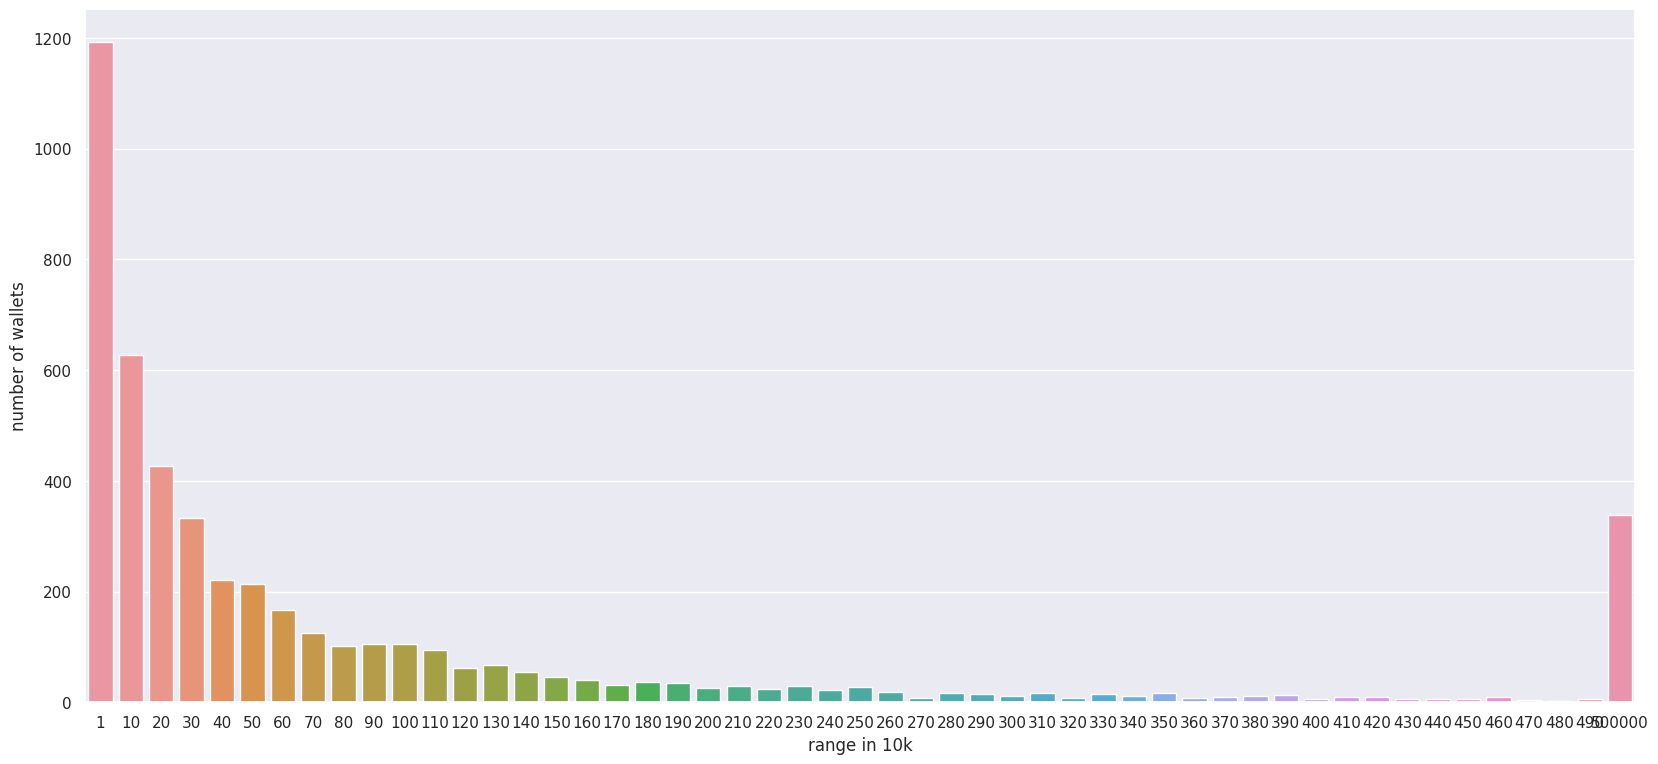

In [4]:
df_0x38_trimmed = df_0x38.iloc[1:]
sns.set(rc={'figure.figsize': (20, 9)})
sns.barplot(data=df_0x38_trimmed, x="range in 10k", y="number of wallets")

In [5]:
levels_list = [5e5, 1e5, 1e4, 1e3]
big_cheese = mongodb.get_number_lps_by_balances_range(chain_ids[0], lower=levels_list[0])
small_fries = mongodb.get_number_lps_by_balances_range(chain_ids[0], upper=levels_list[-1])
print(f"More than {levels_list[0]}: {big_cheese}")
for i in range(len(levels_list)-1):
    n = mongodb.get_number_lps_by_balances_range(chain_ids[0], upper=levels_list[i], lower=levels_list[i+1])
    print(f"{levels_list[i+1]} to {levels_list[i]}: {n}")
print(f"Less than {levels_list[-1]}: {small_fries}")

More than 500000.0: 338
100000.0 to 500000.0: 971
10000.0 to 100000.0: 2321
1000.0 to 10000.0: 1192
Less than 1000.0: 10434


#### LP tokens on 0x1

In [6]:
df_0x1 = get_dataframe('0x1')
df_0x1.head()

,range in 10k,number of wallets
0,0,3291
1,1,660
2,10,291
3,20,211
4,30,166


<Axes: xlabel='range in 10k', ylabel='number of wallets'>

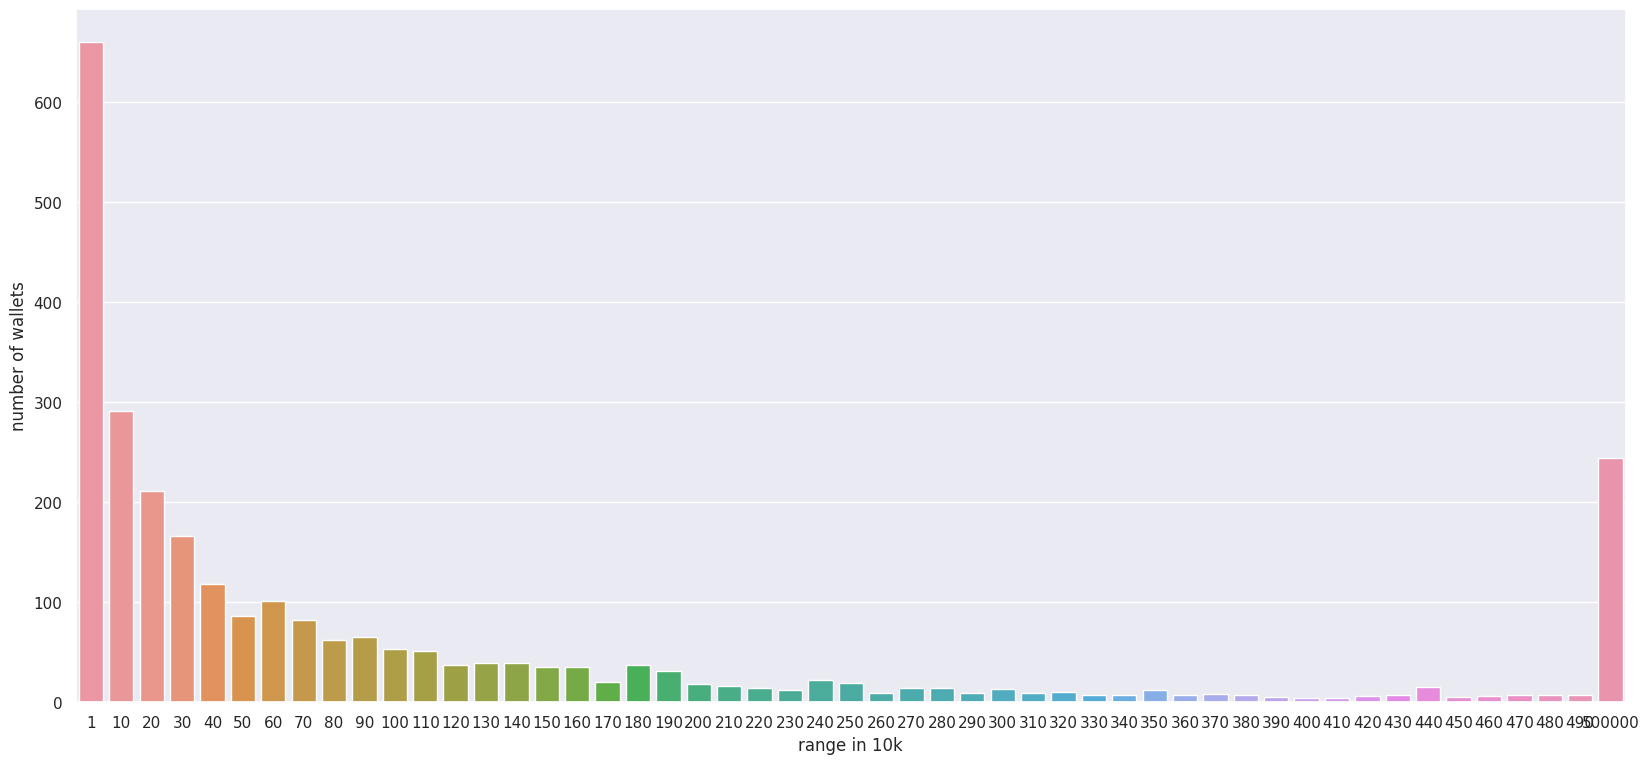

In [7]:
df_0x1_trimmed = df_0x1.iloc[1:]
sns.set(rc={'figure.figsize': (20, 9)})
sns.barplot(data=df_0x1_trimmed, x="range in 10k", y="number of wallets")

In [8]:
levels_list = [5e5, 1e5, 1e4, 1e3]
big_cheese = mongodb.get_number_lps_by_balances_range('0x1', lower=levels_list[0])
small_fries = mongodb.get_number_lps_by_balances_range('0x1', upper=levels_list[-1])

print(f"More than {levels_list[0]}: {big_cheese}")
for i in range(len(levels_list)-1):
    n = mongodb.get_number_lps_by_balances_range('0x1', upper=levels_list[i], lower=levels_list[i+1])
    print(f"{levels_list[i+1]} to {levels_list[i]}: {n}")
print(f"Less than {levels_list[-1]}: {small_fries}")

More than 500000.0: 244
100000.0 to 500000.0: 677
10000.0 to 100000.0: 1182
1000.0 to 10000.0: 660
Less than 1000.0: 3291


#### LP tokens on 0xfa

In [10]:
df_0xfa = get_dataframe('0xfa')
df_0xfa.head()

,range in 10k,number of wallets
0,0,811
1,1,93
2,10,26
3,20,7
4,30,4


<Axes: xlabel='range in 10k', ylabel='number of wallets'>

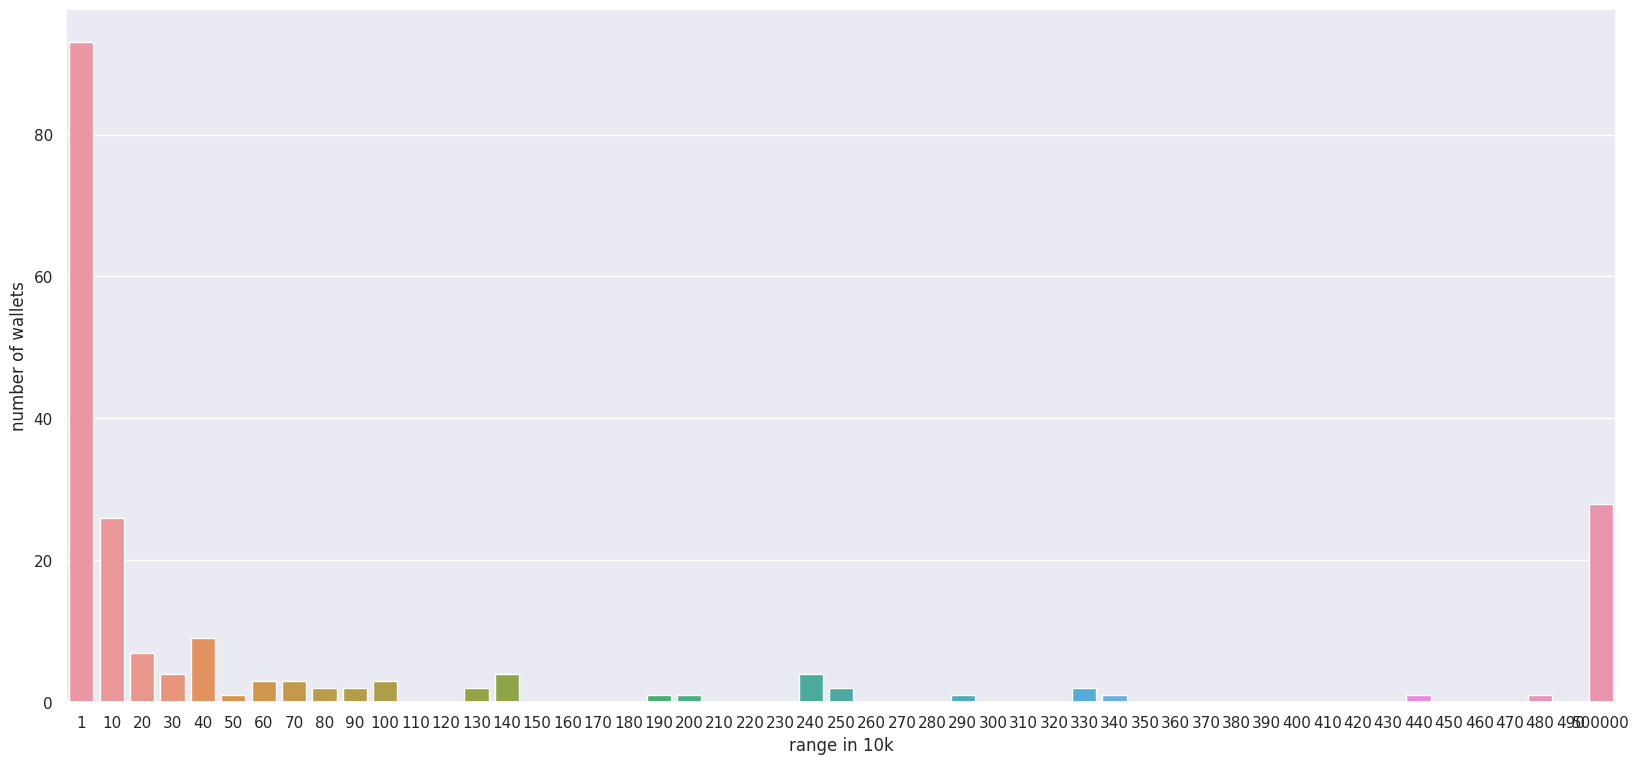

In [11]:
df_0xfa_trimmed = df_0xfa.iloc[1:]
sns.set(rc={'figure.figsize': (20, 9)})
sns.barplot(data=df_0xfa_trimmed, x="range in 10k", y="number of wallets")

In [12]:
levels_list = [5e5, 1e5, 1e4, 1e3]
big_cheese = mongodb.get_number_lps_by_balances_range('0xfa', lower=levels_list[0])
small_fries = mongodb.get_number_lps_by_balances_range('0xfa', upper=levels_list[-1])

print(f"More than {levels_list[0]}: {big_cheese}")
for i in range(len(levels_list)-1):
    n = mongodb.get_number_lps_by_balances_range('0xfa', upper=levels_list[i], lower=levels_list[i+1])
    print(f"{levels_list[i+1]} to {levels_list[i]}: {n}")
print(f"Less than {levels_list[-1]}: {small_fries}")

More than 500000.0: 28
100000.0 to 500000.0: 23
10000.0 to 100000.0: 57
1000.0 to 10000.0: 93
Less than 1000.0: 811


## Dex Traders

In [3]:
c = MongoDB().count_deployed_chains_of_project('lendingpools', 'venus', '0x38')
dexes = ["pancakeswap", "spookyswap"]
for dex in dexes:
    _filter = {f"tradedlps.{dex}": {"$exists": 1}}
    print(f"{dex}: {mongodb.count_wallets(_filter)}")

pancakeswap: 18039
spookyswap: 16275
